# Building a Neural Network with Gradient Descent

# Overview

In this notebook, I created a neural network that classifies handwritten digits using gradient descent. In the introduction section I explain a bit about how the network works and derive some of the math involved, explaining how the gradient helps the network learn. Then I build the network in Python and include the rest of the relevant math alongside the relevant code. And of course, I test it.

Based on [this](https://www.youtube.com/watch?v=aircAruvnKk) awesome 3Blue1Brown video series.

Enjoy!


# Introduction

A simple neural network consists of an input layer, followed by some number of hidden layers, followed by an output layer. Each neuron contains a value called an "activation" and is connected to the neurons in the layer before and after it.

In [1]:
from IPython.display import Image as Img

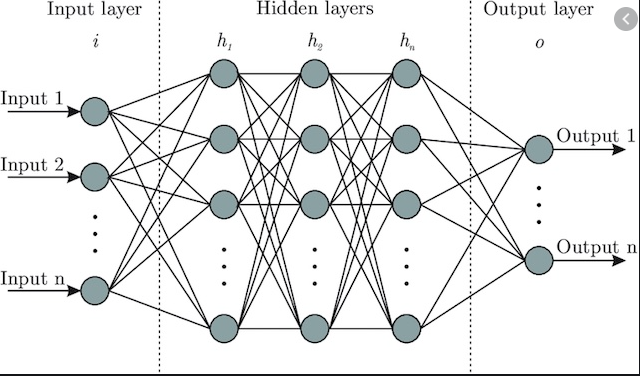

In [46]:
# Credit: https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html
Img("notebook_images/neural_network_img1.png", width=500)

In the example I'm using for this project, the input layer will represent a set of 784 pixel values from an 28x28 image of a handwritten digit, and the 10-neuron output layer will represent the 10 possible digits, 0 through 9. If the output neuron that represents 2 has the highest value in the output layer for a given input image, the model thinks that the image is a 2.

## How the network works, briefly

Each neuron after the input layer is connected to all the neurons in the layer before it. To calculate its activation, it takes a weighted sum of all the previous layer's activations based on a list of "weights" unique to that neuron. We then add a constant "bias" value unique to that neuron, which affects how the sigmoid function (introduced below) treats the outputs. The weights and biases together give the neuron's z-value. Letting $p$ be the number of neurons in the previous layer:

$$z = w_0 a_0 + w_1 a_1 + ... + w_{p-1} a_{p-1} + b$$

We calculate the activation using a special function called the sigmoid (denoted $\sigma$), which is important because it ensures that the output is between 0 and 1 and is nonlinear, both of which help to create a useful network.

$$a = \sigma (z)$$

It will be important later that the derivative of the sigmoid is

$$ \sigma '(z) = \frac{da}{dz} = \sigma(z)(1-\sigma(z)) $$

If the weights and biases are chosen very well, the neurons' activations will work together in such a way that the final layer will classify the image as the correct digit. The difficult part is finding those weights and biases.

## The cost function

The cost function describes how bad a network's prediction was. If we put an image of a 3 into a neural network, we expect an activation close to one for the output neuron that represents 3 and activations close to zero for all other neurons. We can describe the "cost", or how bad the network did, as the sum of the squares of the differences between the expected output and the actual output. In mathematical notation, this is:

$$ \sum_{i=0}^n (a_i-y_i)^2 $$

where $a_i$ represents the activation of the $i$th output neuron and $y_i$ represents its expected value.

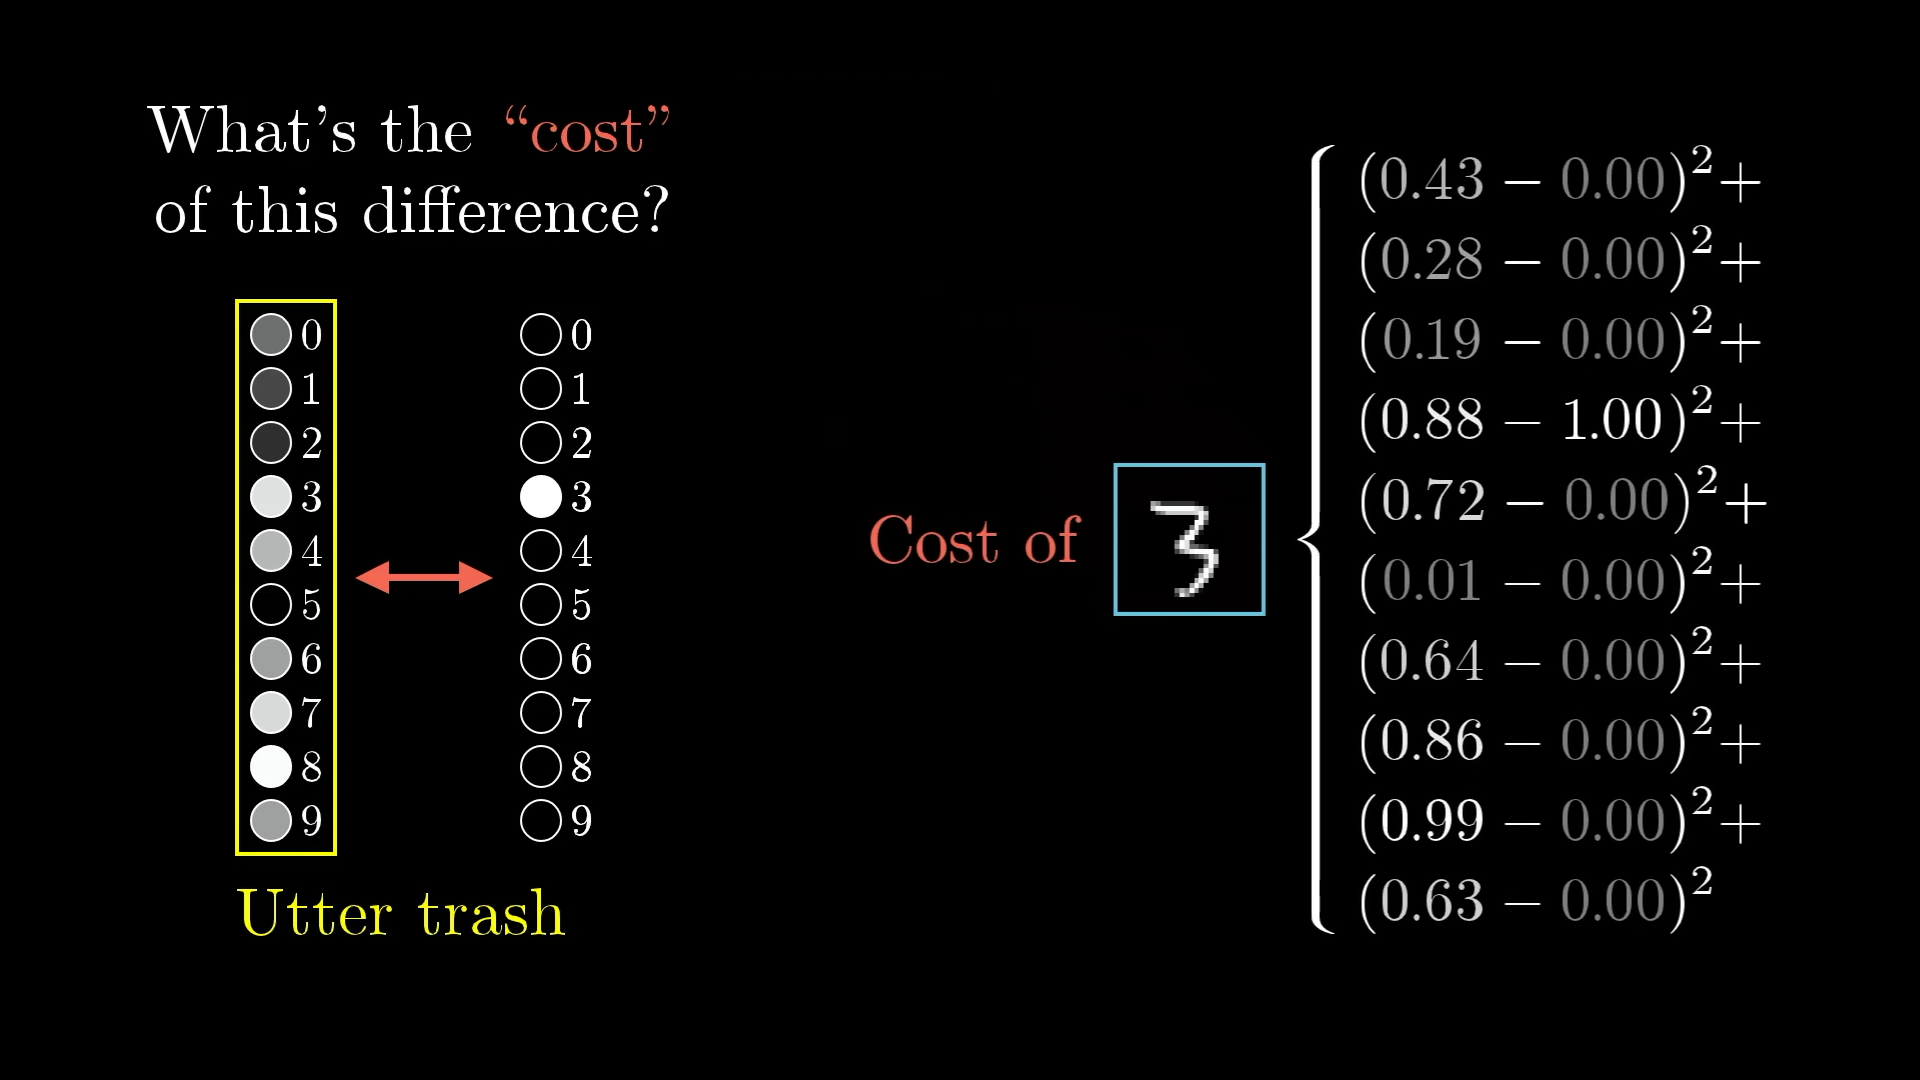

In [4]:
# https://www.3blue1brown.com/lessons/gradient-descent
Img("notebook_images/cost-calculation.png", width=500)

The important takeaway here is that **the lower the average cost, the better the network is**.

## Lowering the cost

From multivariable calculus, we know that the gradient is the direction of steepest ascent; incrementing all input variables by the gradient increases the value of the function the fastest. The reverse is true as well—the negative gradient is the direction of steepest _descent_; incrementing all input variables by the negative gradient will decrease the value of the function the fastest.

Because out neural network is essentially a function of all of our weights and biases, so is the cost. We can represent the cost function as:

$$ C(w_0, w_1, ... , w_k, b_0, b_1, ... b_n)$$

We want to minimize the cost function, or decrease its value as fast as we can. To do so, we can use the negative gradient of the cost function:

$$ -\nabla C= -\bigg( \frac{\partial C}{\partial w_0}, \frac{\partial C}{\partial w_1}, ..., \frac{\partial C}{\partial w_k}, \frac{\partial C}{\partial b_0}, \frac{\partial C}{\partial b_1}, ... , \frac{\partial C}{\partial b_n} \bigg) $$

**Thus, if we repeatedly increment, or "nudge", each weight and bias by the negative partial derivative of the cost function with respect to it, we will approach a local minimum of the cost function and improve the neural network's performance.**

## Finding the partial derivatives

Say we know $-\frac{\partial C}{\partial a}$ for a particular activation in our layer called $a$. We will know this from training image examples and a bit of extra calculation. We want to calculate the amount we need to change each weight and bias for this neuron. Let $w_0, w_1, ... w_{n-1}$ be the weights of this neuron and $b$ be the bias. Then, by the chain rule:

$$-\frac{\partial C}{\partial b}=-\frac{\partial C}{\partial a} \cdot \frac{\partial a}{\partial z}\cdot \frac{\partial z}{\partial b}$$

We know that $a=\sigma(z)$ and $z=\sum_{i=0}^{n-1}w_i a_{\text{prev}, i} + b$, so $\frac{\partial a}{\partial z}=\sigma '(z)$ (which we know) and $\frac{\partial z}{\partial b}=1$, so:

$$-\frac{\partial C}{\partial b}=-\frac{\partial C}{\partial a} \cdot \sigma ' (z)$$

Similarly, since $\frac{\partial z}{\partial w_i}=a_{\text{prev}, i}$:
$$-\frac{\partial C}{\partial b}=-\frac{\partial C}{\partial a} \cdot \sigma ' (z)\cdot a_{\text{prev}, i}=-\frac{\partial C}{\partial b}\cdot a_{\text{prev}, i}$$

Thus, given $-\frac{\partial C}{\partial a}$ we know how to change the weights and biases of a particular neuron.

There is more math involved (for instance, finding $-\frac{\partial C}{\partial a}$), but it has been included in text accompanying the code, because I think all this extensive derivative stuff is getting boring.


# Getting Started

Now that the math fundamentals have been established, we can start coding the neural network! My objective is to create a simple network that can classify handwritten digits from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). Not the most difficult machine learning task in the world, but again, the objective here is more about the math.

The network will be trained on tens of thousands of training images accompanied by labels, using gradient descent to try to find a local minimum of weights and biases. Then it will be tested on thousands more images. If it classifies the vast majority of digits correctly, all that extensive derivative stuff was right!

# The Basics

## Import statements

In [5]:
from PIL import Image
import random
import numpy as np
import os
import matplotlib.pyplot as plt

The `jdc` package helps break up classes over multiple cells in Jupyter notebooks, which is great if you don't like 200-line Jupyter cells.

In [6]:
pip install jdc

Note: you may need to restart the kernel to use updated packages.


In [7]:
import jdc

## Defining the sigmoid function

In [8]:
def sigmoid(z):
    ''' The sigmoid function. '''
    return (1 / (1 + np.exp(-z)))

In [9]:
def sigmoid_deriv(z):
    ''' The derivative of the sigmoid function. '''
    return sigmoid(z) * (1 - sigmoid(z))

## Defining learning parameters and important constants

It might seem a bit redundant that I'm defining a list of classes for the digits 0 through 9 and relating those classes to the indices 0 through 9. I wrote it this way so that if I ever want to adapt this code to recognize anything that's not a series of sequential digits, I would only have to change these two lines. But yes, it's unnecessary for this example.

In [10]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
CLASS_INDEX = {CLASSES[i]:i for i in range(len(CLASSES))}

In [11]:
# Creating a network with one 784-pixel image layer, a 1500-neuron layer, a 500-neuron layer, a 30-neuron layer
# and a 10-neuron final layer representing the ten digits.
MODEL_LAYERS = [784, 1500, 500, 30, 10]

In [12]:
def IMG_TO_ARRAY(path):
    ''' Converts an image given at a particular path to an array of 784 pixel values from 0 to 1. '''
    with Image.open(path) as im:
        return (np.asarray(im) / 256).flatten()

In [13]:
BASE_PATH_TRAIN = "mnist/train/"
BASE_PATH_TEST = "mnist/test/"

# Layer classes

The following defines `ImageLayer` for the input image layer (leftmost on most diagrams), `NeuronLayer` for each activation layer of neurons, and `TruthLayer` for the expected output layer (the "ground truth"). These classes implement the neural network, the relationships between activations, and the gradient descent mechanism.

## Image Layer

In [14]:
class ImageLayer:
    '''The initial (input image) layer. Use setImage to set the activations and getActivations to read them.'''
    
    def __init__(self, length):
        self._activations = np.zeros(length)
        self._length = length
    
    def __len__(self):
        return self._length
    
    def setImage(self, pixels):
        ''' Sets the node activations to the intensity (0-1) of the pixels given in a numpy array.
        Must have the same length as the activation layer. '''
        assert len(pixels) == self._length
        self._activations = pixels
        
    def getActivations(self):
        return self._activations
    
    def computeGradients(self): # This shouldn't be called, but just in case
        pass

## Neuron Layer

In [15]:
class NeuronLayer:
    ''' Defines a typical activation layer of neurons. '''
    
    def __init__(self, length, prevLayer):
        ''' 
        Initializes NeuronLayer with random weights and biases, empty arrays for nudges to weights and biases,
        and empty activations and z-values. Also stores a reference to the previous layer.
        '''
        
        self.length = length
        self.prevLayer = prevLayer # Store the previous layer to access activations.
        
        # Let p = length of previous layer, t = length of this layer.
        p = len(self.prevLayer)
        t = self.length
        
        # Store data for neurons. 
        self._weights = 2 * np.random.rand(t, p) - 1 # weights: array[t, p] of random numbers on [-1, 1]
        self._biases = np.random.rand(t) - 0.5 # biases: array[t] of random numbers  on [-0.5, 0.5]
        
        self._zvalues = np.zeros(t) # z values: empty array[t]
        self._activations = np.zeros(t)  # activations: empty array[t]
        
        # Accumulate weight nudges
        self._biasNudges = np.zeros(t)  # bias nudges: empty array[t]
        self._weightNudges = np.zeros((t, p)) # weight nudges: empty array[t, p]
        
        # Counter for number of training examples since last updating arguments
        self._batch_size = 0

These simple helper methods will make accessing the values of other layers easier:

In [16]:
%%add_to NeuronLayer
def __len__(self):
    return self.length

def getActivations(self):
    ''' Returns numpy array of activations for the neurons in this layer. '''
    return self._activations

The method `computeActivations` calculates the z-values and activations of this layer based on the activations of the previous layer and the weights and biases stored for this layer. It follows the formulas:

$$z = W\cdot A_\text{prev} + B\\
A_\text{this} = \sigma(z)$$

where $W$ is the $[t\times p]$ matrix of weights, $A_\text{prev}$ is the $[p\times 1]$ matrix of previous layer activations, and $B$ is the $[t\times 1]$ layer of biases.

In [17]:
%%add_to NeuronLayer
def computeActivations(self):
    ''' Updates the activations of this layer using the activations of the previous layer
    and the current weights and biases.'''
    
    w = self._weights
    a_prev = self.prevLayer.getActivations()
    b = self._biases
    
    self._zvalues = np.matmul(w, a_prev) + b
    self._activations = sigmoid(self._zvalues)

### Gradient Descent

(In the following section, I use the word "nudge" to refer to a small increment to a particular variables to get the cost function to move in the direction of gradient descent.)

The `computeGradients` method performs the gradient descent calculations given the desired changes to the activations of this layer, or the set of partial derivatives:

$$ \text{activationNudges}= \bigg(-\frac{\partial C_k}{\partial a_0}, -\frac{\partial C_k}{\partial a_1}, ...
-\frac{\partial C_k}{\partial a_T}\bigg)$$

where $C_k$ represents the cost of this training example, $t$ is an index for this layer's neurons, and $T$ represents the size of this layer.

It uses the formulas:

$$ \text{oneRoundBiasNudge}_t = -\frac{\partial C_k}{\partial b_t} = -\frac{\partial C_k}{\partial a_t} \cdot \sigma ' (z_t) = \text{activationNudge}_t\cdot \text{sigmoid_deriv}(z_t)$$

and

$$ \text{oneRoundWeightNudge}_t = -\frac{\partial C_k}{\partial w_{t, p}} = -\frac{\partial C_k}{\partial a_t} \cdot \sigma ' (z_t) \cdot \frac{\partial z_t}{\partial w_{t, p}} = \text{oneRoundBiasNudge}_t \cdot \text{previousActivations}_{p} $$

where $p$ is an index for the previous layers' neurons.

Finally, unless the previous layer is the image input layer, we need to tell the previous layer how much its activations need to change (providing the `activationNudges` parameter for them). For this, we use the formula:

$$\text{prevLayerActivationNudges}_p = -\frac{\partial C_k}{\partial a_{\text{prev},p}} = \sum_{t = 0}^{T} \bigg(-\frac{\partial C_k}{\partial a_t} \cdot \sigma ' (z_t) \cdot \frac{\partial z_t}{\partial a_{\text{prev},p}}\bigg) = \text{oneRoundBiasNudge}_t \cdot w_{t, p}$$

The summation is required because of the Multivariable Chain Rule; since different neurons in this layer want the previous layer's activations to change in different ways, each neuron in the previous layer must sum up the partial derivatives from each neuron in this layer.

These nudges to the previous activation layer can be calculated by

$$ \text{prevLayerActivationNudges} = W^T \cdot \text{oneRoundBiasNudges}$$

where $W^T$ represents the transpose of the $[t \times p]$ weight matrix.

In [18]:
%%add_to NeuronLayer
def computeGradients(self, activationNudges):
    ''' Calculates the negative gradients of the cost function with respect to each weight and bias (how
    much to nudge each weight and bias), incrementing the _biasNudges and _weightNudges arrays accordingly.
    Also determines how much to nudge activations of previous layer and calls computeGradients for that
    layer, passing the appropriate calculations as input. '''
    
    self._batch_size += 1
    
    a_prev = self.prevLayer.getActivations() # get array[p] of previous activation nudges
    
    # calculate weight and bias nudges for this one training example
    oneRoundBiasNudges = np.multiply(activationNudges, sigmoid_deriv(self._zvalues))
    oneRoundWeightNudges = np.array([np.multiply(biasRow, a_prev) for biasRow in oneRoundBiasNudges])
    
    # Increment counter of weight and bias nudges 
    self._biasNudges += oneRoundBiasNudges
    self._weightNudges += oneRoundWeightNudges

    if not isinstance(self.prevLayer, ImageLayer):
        
        # find activation nudges for last layer: sum of bias nudges for each node in this layer times its weight 
        # compute gradients for that layer

        prevLayerActivationNudges = np.matmul(self._weights.T, oneRoundBiasNudges)
        self.prevLayer.computeGradients(prevLayerActivationNudges) # ask previous layer to compute gradients


Finally, `updateArguments` takes the cumulative sum of the nudges to the weights and biases and scales them based on the number of training examples and the learning rate.

In [19]:
%%add_to NeuronLayer
def updateArguments(self):
    ''' Uses the values of the _weightNudges and _biasNudges arrays to increment the layer's weights and
    biases. Adjusts for batch size and learning rate. Resets the values of the _weightNudges and _biasNudges
    array to 0. '''
    
    # Adjusts values of weightNudges and biasNudges by the learning rate and batch size.
    self._weightNudges = self._weightNudges * LEARNING_RATE / self._batch_size
    self._biasNudges = self._biasNudges * LEARNING_RATE / self._batch_size

    # Nudges the weights and biases
    self._weights += self._weightNudges
    self._biases += self._biasNudges

    # Resets the arrays and the batch size
    self._weightNudges.fill(0)
    self._biasNudges.fill(0)
    self._batch_size = 0


## Truth Layer

The truth layer stores the expected values of the output layer, used for training and for evaluating cost. In some ways it serves as an interface for the neural network, mostly because I've set up the network in such a way that each layer class can most easily access information about the layer behind it.

In [47]:
class TruthLayer:
    ''' Defines the truth layer of expected output values. '''
    
    def __init__(self, finalLayer):
        self.length = len(finalLayer)
        self.finalLayer = finalLayer
        self.truthNodes = np.zeros(self.length)
    
    def newTruth(self, i):
        ''' Resets the values of the truth layer based on the class index provided. '''
        assert 0 <= i < len(self.truthNodes)
        self.truthNodes.fill(0)
        self.truthNodes[i] = 1.0
    
    def getCost(self):
        ''' Returns the cost based on the values of the final activation layer and the values of the
        truth layer. '''
        finalActivations = self.finalActivations()
        return np.sum(np.square(finalActivations - self.truthNodes))

    def finalActivations(self):
        ''' Returns activations in the final layer. '''
        return self.finalLayer.getActivations()
    

### Gradient Descent

To allow the previous layers to compute their gradients, we must calculate the activation nudges to the final layer, or:

$$ \text{activationNudges}= \bigg(-\frac{\partial C_0}{\partial a_0}, -\frac{\partial C_0}{\partial a_1}, ...
-\frac{\partial C_0}{\partial a_{n-1}}\bigg)$$

where $a_0, a_1, ... a_{n-1}$ represent the activations of the final layer's neurons, and letting $n$ be the number of classes.

Let $y_0, y_1, ... y_{n-1}$ represent the expected values of the final layer (the values of the truth layer). The cost of this training example, $C_0$, is given by

$$C_0 = \sum_{k = 0}^{n-1} \big(a_k - y_k\big)^2 $$

Then,

$$ \frac{\partial C_0}{\partial a_i} = \frac{\partial}{\partial a_i}\sum_{k = 0}^{n-1} \big(a_k - y_k\big)^2 = \frac{\partial}{\partial a_i}\big(a_i - y_i\big)^2 = \frac{\partial}{\partial a_i}\big(a_i^2 - 2a_iy_i + y_i^2\big) = 2a_i-2y_i$$

Therefore,

$$ \text{activationNudges}_i = -\frac{\partial C_0}{\partial a_i} = -(2a_i-2y_i) = 2y_i-2a_i $$

In [21]:
%%add_to TruthLayer
def computeGradients(self):
    ''' Calculates the nudges to each activation in the final layer and calls computeGradients on that layer,
    passing those nudges as input. '''
    
    activationNudges = 2 * self.truthNodes - 2 * self.finalLayer.getActivations() # 2y_i - 2a_i
    self.finalLayer.computeGradients(activationNudges)

# Creating the network

Now that the frameworks for the layers have all been constructed, we can put it all together with the `Net` class, which serves as an interface for the entire neural network.

In [22]:
class Net:
    ''' Defines a fully-connected neural network. '''
    
    def __init__(self, layers=MODEL_LAYERS):
        ''' Given a list of integer layer sizes, creates a neural network comprised of an ImageLayer, a list of
        NeuronLayers, and a TruthLayer.'''
        
        assert len(layers) > 1
        self.imageLayer = ImageLayer(layers[0]) # The first layer is the input layer
        
        # Create list of NeuronLayer objects for each neuron layer
        self.neuronLayers = []
        prevLayer = self.imageLayer
        for layerSize in layers[1:]:
            newLayer = NeuronLayer(layerSize, prevLayer)
            self.neuronLayers.append(newLayer)
            prevLayer = newLayer
        
        # Create a truth layer connected to the last neuron layer.
        self.truthLayer = TruthLayer(self.neuronLayers[-1])

The following are simple helper methods for `Net`.

In [23]:
%%add_to Net
def computeActivations(self):
    ''' Computes activations for each neuron layer in order. '''
    for layer in self.neuronLayers:
        layer.computeActivations()

def computeGradients(self):
    ''' Uses backpropagation to compute one round of gradient nudges for the current training example.'''
    self.truthLayer.computeGradients()

def finalActivations(self):
    ''' Returns the activations of the final layer of the neural network. '''
    return self.truthLayer.finalActivations()

def updateArguments(self):
    ''' Updates the weights and biases in each layer based on the running total of weight and bias nudges. '''
    for layer in self.neuronLayers:
        layer.updateArguments()

The method `trainPoint` trains the model on one training example given by an image path and a true label.

In [24]:
%%add_to Net
def trainPoint(self, path, label):
    ''' Trains model on one training example given at a path with a label (not an index). 
    Does not update model arguments. Returns the cost of this training example.'''
    
    # get array of pixels
    im_array = IMG_TO_ARRAY(path)
    
    # updates input image layer and truth layer
    self.truthLayer.newTruth(CLASS_INDEX[label])
    self.imageLayer.setImage(im_array)
    
    # calculate new activations, increment weight and bias nudges
    self.computeActivations()
    self.computeGradients()
    
    # return cost of training example
    return self.truthLayer.getCost()

Finally, `__call__` allows a client to call `net(path)` (where `net` is an instance of `Net`) to determine the output of the neural network for the image at the given path. By default, the function will return the class which the network has classified the image as. Passing `result = "activations"` will make the function return the activations of the final layer instead, which could be useful for determining the cost over all test data.

In [25]:
%%add_to Net
def __call__(self, path, result="class"):
    ''' Given a path to an image, returns the class which the network believes the image is. Passing 
    result="activations" will make the function return the activations of the final layer instead. '''
    
    # get array of pixels, updates input image layer
    im_array = IMG_TO_ARRAY(path)
    self.imageLayer.setImage(im_array)
    
    # calculate new activations for each layer
    self.computeActivations()
    
    # get final layer's activations
    output = self.finalActivations()
    
    if result == "activations":
        return output # return activations of final layer
    
    # find index of highest-intensity activation, return corresponding class
    index = np.argmax(output)
    return CLASSES[index]
            

# Training a Network

## Creating list of training image paths

This code iterates through all the images in the training image folder. For each, it creates a dictionary with a `"path"` key corresponding to the image's file path and a `"label"` key corresponding to its label. The list `trainSet` contains all these dictionaries.

In [26]:
BASE_PATH_TRAIN = "mnist/train/"

In [27]:
trainSet = []
for label in CLASSES:
    prefix = BASE_PATH_TRAIN + str(label) + "/"
    for filename in os.listdir(prefix): # iterate through every file in the folder for each class
        trainSet.append({"path": (prefix+filename), "label": label})

In [28]:
random.shuffle(trainSet)
trainSet[:5]

[{'path': 'mnist/train/2/54831.jpg', 'label': 2},
 {'path': 'mnist/train/8/3026.jpg', 'label': 8},
 {'path': 'mnist/train/9/15195.jpg', 'label': 9},
 {'path': 'mnist/train/3/5412.jpg', 'label': 3},
 {'path': 'mnist/train/6/22333.jpg', 'label': 6}]

## Initializing and training the neural network

First, review two parameters for our network, learning rate and batch size. Learning rate describes how much a network increments its weights and biases in each cycle, and batch size refers to how many training examples it looks at before making an adjustment to those parameters.

In [29]:
LEARNING_RATE = 0.02
BATCH_SIZE = 2

We define a function to train one batch of data given a sublist of `trainSet`. This corresponds to one "cycle" of looking at a few training examples (determined by batch size) and updating the weights and biases.

In [30]:
def trainBatch(batch):
    ''' Trains one batch of training examples given in the form [{"path": path1, "label": label1}, ...].
    Does not enforce the batch size being the same as the constant. Updates the weights and biases after
    passing all examples in the batch and returns the average cost.
    '''
    totalCost = 0
    batch_size = len(batch)
    
    # Iterate item over batch; item is of the form {"path": path1, "label": label1}
    for item in batch:
        # use trainPoint method to train model on one example, increment totalCost
        totalCost += net.trainPoint(item["path"], item["label"])
    
    # nudge weights and biases
    net.updateArguments()
    
    # return average cost
    return totalCost / batch_size

Initialize the network!

In [31]:
net = Net()

To check later whether the average cost of a batch actually decreased over time (and how quickly it did so), we initialize an array of costs. This is more for curiosity than anything else.

In [32]:
cost = []

Initialize some more useful constants:

In [33]:
UPDATE_SIZE = 1000 # Determines how often the progress is printed to the console
EPOCHS = 5 # Number of epochs (times we go over the whole dataset)

### Training

Now, we can actually train the model! (This will take a few minutes.)

In [34]:
for epoch in range(epochs): # Iterate over the whole dataset some number of times
    
    batch_num = 0 # Initialize counter for number of batches

    for i in range(0, len(trainSet) - BATCH_SIZE, BATCH_SIZE):
        
        batch_num += 1
        batch = trainSet[i:i+BATCH_SIZE] # Create batch as subset of trainSet
        
        currentCost = trainBatch(batch) # Train on current batch, updating parameters
        cost.append(currentCost) # Add average cost to list
        
        if batch_num % UPDATE_SIZE == 0:
            # print progress so far, and a rough estimate of the cost of the model at this point
            costAvgLast10Percent = sum(cost[-(UPDATE_SIZE//10):]) / (UPDATE_SIZE//10)
            print(f"Epoch: {epoch + 1}, Batch {batch_num}, Cost: {costAvgLast10Percent}")
    
    random.shuffle(trainSet) # shuffle the order of the images

print("Finished training.")

Epoch: 1, Batch 1000, Cost: 0.8810668779342034
Epoch: 1, Batch 2000, Cost: 0.8549691318481689
Epoch: 1, Batch 3000, Cost: 0.7838393176672307
Epoch: 1, Batch 4000, Cost: 0.7691922860709277
Epoch: 1, Batch 5000, Cost: 0.6917894840661772
Epoch: 1, Batch 6000, Cost: 0.610349443040359
Epoch: 1, Batch 7000, Cost: 0.5722027842274755
Epoch: 1, Batch 8000, Cost: 0.6007659940936328
Epoch: 1, Batch 9000, Cost: 0.5667885456538387
Epoch: 1, Batch 10000, Cost: 0.5426648669623946
Epoch: 1, Batch 11000, Cost: 0.47107131894416976
Epoch: 1, Batch 12000, Cost: 0.4827402868376173
Epoch: 1, Batch 13000, Cost: 0.4100211620511896
Epoch: 1, Batch 14000, Cost: 0.4414368844590617
Epoch: 1, Batch 15000, Cost: 0.41904297766316034
Epoch: 1, Batch 16000, Cost: 0.3889786523117645
Epoch: 1, Batch 17000, Cost: 0.32816077987795345
Epoch: 1, Batch 18000, Cost: 0.33667284479728243
Epoch: 1, Batch 19000, Cost: 0.31177076696233785
Epoch: 1, Batch 20000, Cost: 0.3264906524495851
Epoch: 1, Batch 21000, Cost: 0.32595893056151

We can look at how the cost function changed over time because of the data we saved in the `cost` list. (Remember that these costs are for small batch sizes, so a lot of variation is expected.)

Text(0, 0.5, 'log(cost)')

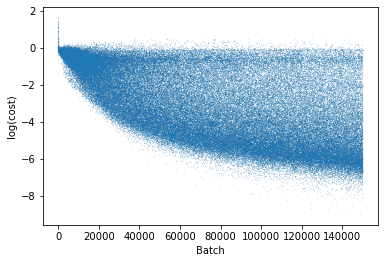

In [35]:
plt.scatter(range(len(cost)), np.log(cost), s=0.005)
plt.xlabel("Batch")
plt.ylabel("log(cost)")

We can also get an idea of what the cost function was like toward the beginning of training, versus toward the end, using some simple averages.

In [36]:
print(f"Cost at beginning of training: {sum(cost[:100]) / 100}")
print(f"Cost at end of training: {sum(cost[-100:]) / 100}")

Cost at beginning of training: 1.0284771870346792
Cost at end of training: 0.07706447760927279


# Testing the network

To determine the success of our model, we can find the percent of test examples the model identifies correctly.

## Creating list of test images

Just as with the training images, we can create a list of paths and labels for test images.

In [37]:
BASE_PATH_TEST = "mnist/test/"

In [38]:
testSet = []
for i in range(10):
    prefix = BASE_PATH_TEST + str(i) + "/"
    for filename in os.listdir(prefix):
        testSet.append({"path": (prefix+filename), "label": i})

In [39]:
random.shuffle(testSet)
testSet[:5]

[{'path': 'mnist/test/1/7023.jpg', 'label': 1},
 {'path': 'mnist/test/7/5064.jpg', 'label': 7},
 {'path': 'mnist/test/7/5688.jpg', 'label': 7},
 {'path': 'mnist/test/6/8697.jpg', 'label': 6},
 {'path': 'mnist/test/8/8958.jpg', 'label': 8}]

## Testing

Now, the model will receive all test images in the `test` folder and attempt to classify them. We will record the percent correct and save the images it got wrong in a list called `failures`.

In [40]:
failures = [] 

# Initialize the counters for correct predictions and total predictions to 0
correct_pred = 0
total_pred = 0 

# Iterate item over testSet; item is of the form {"path": path1, "label": label1}
for item in testSet: 
    total_pred += 1
    
    predicted_label = net(item["path"]) # Get output of neural network for image at this path
    
    if item["label"] == predicted_label: # if the model was correct
        correct_pred += 1
    else:
        failures.append({"path":item["path"], "prediction":predicted_label})

## Performance

Run this cell to see what percent of the images the network classified correctly.

In [41]:
print(f"The model classified {(correct_pred * 100 / total_pred):.2f}% of the test images correctly.")

The model classified 93.93% of the test images correctly.


Not half bad!

(You could run something similar for the training image and compare percentages to check for overfitting. But determining overfitting is not really the point of this notebook and this is getting pretty long already, so I'm not including those tests here.)

### Random test image

Run the cell below to generate a random image and see what the network classifies it as.

In [42]:
randomPath = random.choice(testSet)["path"]
print(net(randomPath))
Image.open(randomPath)

2


### Images the model got wrong

Run the cell below to generate a random image from those it got wrong (the `failures` list) and see what the network incorrectly said it was.

In [45]:
randomFailure = random.choice(failures)
print(f'Model\'s prediction: {randomFailure["prediction"]}')
Image.open(randomFailure["path"])

7


# Conclusion

By calculating the partial derivatives with respect to the weights and biases of each neuron, we found a local minimum of the cost function, improving our neural network. It is now a fairly reliable classifier of handwritten digits through the magic of gradient descent and the multivariable chain rule.

Credit to 3Blue1Brown for the inspiration for this project, and also for being an all-around wonderful channel. And thank you for reading this far!

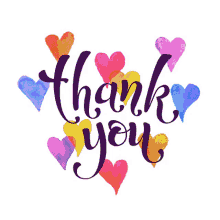

In [44]:
Img("https://c.tenor.com/Q-ZluNT3M0sAAAAM/thank-you-thanking-you.gif")